In [19]:
import xarray as xr
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
from datetime import datetime
import gsw

from scipy.interpolate import griddata

In [20]:
topo_file = 'grid/gebco_2023_n29.6_s27.8_w34.2_e35.1.nc'
grid_name = 'gulf_eilat'
author = 'Victor Gabel'
source = 'GEBCO 2023'
new_dx = 2000
new_dy = 2000

In [21]:
topo = xr.open_dataset(topo_file)
topo

<xarray.Dataset> Size: 192kB
Dimensions:    (lat: 432, lon: 216)
Coordinates:
  * lat        (lat) float64 3kB 27.8 27.81 27.81 27.81 ... 29.59 29.59 29.6
  * lon        (lon) float64 2kB 34.2 34.21 34.21 34.21 ... 35.09 35.09 35.1
Data variables:
    elevation  (lat, lon) int16 187kB ...
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

In [22]:
elev = topo.elevation.values*-1
elev[elev<0] = 0

In [23]:
mean_lat = float(topo.lat.mean().values)
mean_lon = float(topo.lon.mean().values)

x = gsw.distance(topo.lon, [mean_lat]*len(topo.lon))
y = gsw.distance([mean_lon]*len(topo.lat), topo.lat)

x = np.append(0, np.cumsum(x))
y = np.append(0, np.cumsum(y))

mx, my = np.meshgrid(x, y)

In [24]:
dx = x[1] - x[0]
dy = y[1] - y[0]

dx, dy

(np.float64(406.39251385307216), np.float64(463.3121943518277))

In [25]:
xn = np.arange(x[0], x[-1], new_dx)
yn = np.arange(y[0], y[-1], new_dy)

mxn, myn = np.meshgrid(xn, yn)

nelev = griddata((mx.ravel(), my.ravel()), topo.elevation.values.ravel()*-1, (mxn, myn), method='cubic')
lon = griddata((x), topo.lon.values, xn)
lat = griddata((y), topo.lat.values, yn)
nelev[nelev<0] = 0

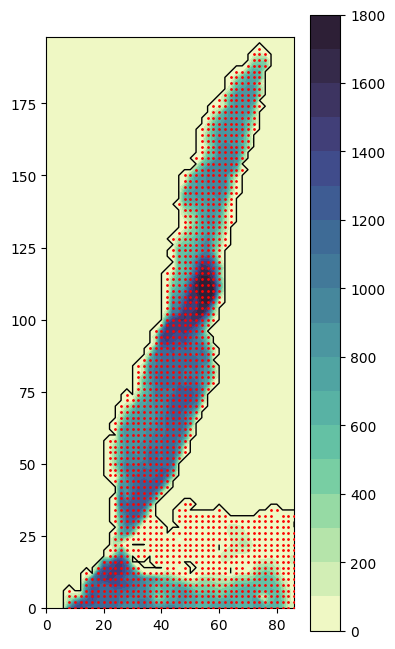

In [26]:
plt.figure(figsize=(4, 8))
plt.contourf(mxn/1000, myn/1000, nelev, cmap=cm.deep, levels=20)
plt.colorbar()
plt.contour(mxn/1000, myn/1000, nelev, levels=[0], colors='k', linewidths=1)
plt.scatter(mxn[nelev > 0]/1000, myn[nelev > 0]/1000, s=1, c='r', zorder=100)
plt.axis('scaled')
plt.show()

In [27]:
grid = xr.Dataset(
    coords=dict(
        x=(["x"], xn),
        y=(["y"], yn),
    ), 
    data_vars=dict(
        elev=(["y", "x"], nelev),
        lon=(("x"), lon),
        lat=(("y"), lat)
    ),
    attrs=dict(
        dx=dx,
        dy=dy,
        mean_lat=mean_lat,
        created=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        author=author,
        description='Grid created with GridTool.ipynb',
        data_source=source,
        interpolation='cubic'
    )
)

grid.to_netcdf("grid/" + grid_name + '.nc')